## Import data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib.cbook import boxplot_stats
plt.rcParams['figure.figsize'] = [14, 6]
plt.style.use('ggplot')

In [0]:
folder_path = '/content/drive/My Drive/WCA/Procurement Project/data/'
files = ['final_ben.csv']

In [0]:
ben_df = pd.read_csv(folder_path +files[0], delimiter=',')
ben_df.head(5)

,BEN_EXPENSE_COA_CENTER_NAME,BEN_TRANSACTION_AMOUNT,transaction_year,transaction_month,BENFPRD_PO_SHIPTO_ADDRESS1_freq_1.0,BENFPRD_PO_SHIPTO_ADDRESS1_freq_2.0,BENFPRD_PO_SHIPTO_ADDRESS1_freq_6.0,BENFPRD_PO_SHIPTO_ADDRESS1_freq_425.8000000000002,BENFPRD_PO_SHIPTO_ADDRESS1_freq_230587.86804397954,BENFPRD_PO_SHIPTO_LOC_CODE_freq_1.0,BENFPRD_PO_SHIPTO_LOC_CODE_freq_2.0,BENFPRD_PO_SHIPTO_LOC_CODE_freq_6.0,BENFPRD_PO_SHIPTO_LOC_CODE_freq_413.0,BENFPRD_PO_SHIPTO_LOC_CODE_freq_230544.4944849504,BEN_EXPENSE_COA_PROGRAM_CODE_freq_1.0,BEN_EXPENSE_COA_PROGRAM_CODE_freq_2.0,BEN_EXPENSE_COA_PROGRAM_CODE_freq_8.0,BEN_EXPENSE_COA_PROGRAM_CODE_freq_278.4000000000001,BEN_EXPENSE_COA_PROGRAM_CODE_freq_2170.8999999999974,BEN_EXPENSE_COA_CREF_CODE_freq_1.0,BEN_EXPENSE_COA_CREF_CODE_freq_2.0,BEN_EXPENSE_COA_CREF_CODE_freq_9.0,BEN_EXPENSE_COA_CREF_CODE_freq_189.0,BEN_EXPENSE_COA_CREF_CODE_freq_1075.0,BEN_EXPENSE_COA_OBJ_CATEGORY_Academic Salaries,BEN_EXPENSE_COA_OBJ_CATEGORY_Capital Transactions,BEN_EXPENSE_COA_OBJ_CATEGORY_Cash Effect,BEN_EXPENSE_COA_OBJ_CATEGORY_Current Expense,BEN_EXPENSE_COA_OBJ_CATEGORY_Investment Income,BEN_EXPENSE_COA_OBJ_CATEGORY_Other Income,BEN_EXPENSE_COA_OBJ_CATEGORY_Tuition & Fees,BEN_EXPENSE_COA_FUND_TYPE_Endowments,BEN_EXPENSE_COA_FUND_TYPE_Gifts,BEN_EXPENSE_COA_FUND_TYPE_Grants,BEN_EXPENSE_COA_FUND_TYPE_Other Purposes,BEN_EXPENSE_COA_ORG_DESC_freq_1.0,BEN_EXPENSE_COA_ORG_DESC_freq_5.0,BEN_EXPENSE_COA_ORG_DESC_freq_90.0,BEN_EXPENSE_COA_ORG_DESC_freq_1036.6,BEN_EXPENSE_COA_ORG_DESC_freq_2388.9,BEN_EXPENSE_COA_FUND_CODE_freq_1.0,BEN_EXPENSE_COA_FUND_CODE_freq_2.0,BEN_EXPENSE_COA_FUND_CODE_freq_4.0,BEN_EXPENSE_COA_FUND_CODE_freq_85.0,BEN_EXPENSE_COA_FUND_CODE_freq_202.0,BEN_EXPENSE_COA_OBJECT_CODE_freq_1.0,BEN_EXPENSE_COA_OBJECT_CODE_freq_2.0,BEN_EXPENSE_COA_OBJECT_CODE_freq_19.599999999999994,BEN_EXPENSE_COA_OBJECT_CODE_freq_2058.8,BEN_EXPENSE_COA_OBJECT_CODE_freq_9124.600000000002,BEN_VENDOR_NAME_freq_1.0,BEN_VENDOR_NAME_freq_2.0,BEN_VENDOR_NAME_freq_3.0,BEN_VENDOR_NAME_freq_4.0,BEN_VENDOR_NAME_freq_153971.0,BEN_RECORD_IDENTIFIER_freq_1.0,BEN_RECORD_IDENTIFIER_freq_2.0,BENFPRD_PO_BUYER_PENN_ID_freq_102.0,BENFPRD_PO_BUYER_PENN_ID_freq_328.0,BENFPRD_PO_BUYER_PENN_ID_freq_53243.05800000251,BENFPRD_PO_BUYER_PENN_ID_freq_231278.0,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_1.0_y,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_2.0_y,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_36391.71999999994_y,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_130195.299999999_y,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_607751.1008600069_y
0,Perelman School of Medicine,256.97,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
1,Perelman School of Medicine,402.03,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
2,Perelman School of Medicine,71.49,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
3,Perelman School of Medicine,206.04,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
4,Perelman School of Medicine,381.76,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0


In [0]:
ben_df['BEN_EXPENSE_COA_CENTER_NAME'].nunique()

44

## Number of entries per center

In [0]:
transactions_per_center = ben_df.groupby(['BEN_EXPENSE_COA_CENTER_NAME']).count().sort_values('BEN_TRANSACTION_AMOUNT',ascending=False)['BEN_TRANSACTION_AMOUNT']

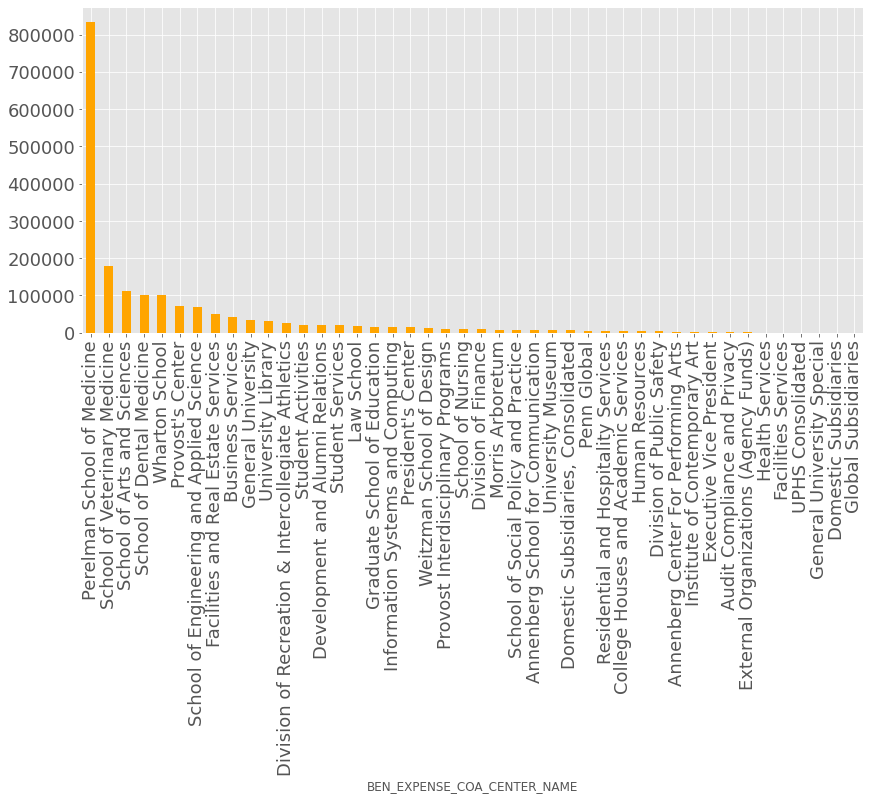

In [0]:
transactions_per_center.plot.bar(fontsize=18, color="orange")

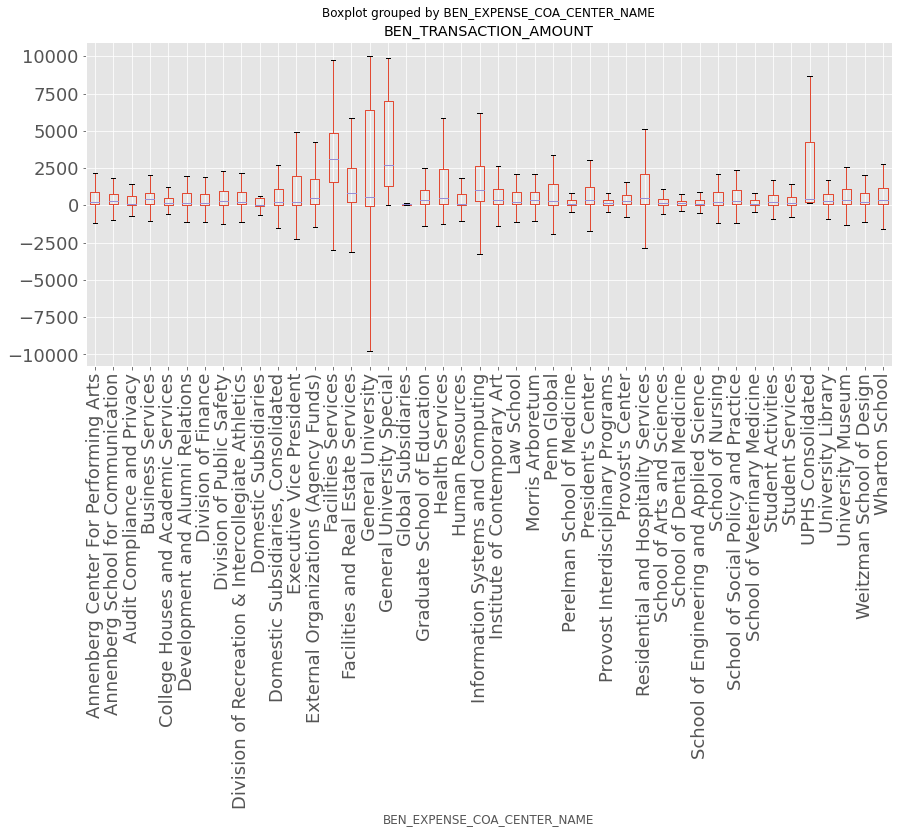

In [0]:
ben_df[ben_df['BEN_TRANSACTION_AMOUNT']<10000].boxplot(column=['BEN_TRANSACTION_AMOUNT'], by='BEN_EXPENSE_COA_CENTER_NAME', rot=90,showfliers=False,fontsize=18)

## Select centers to analyze data

For our presentation, we analyze four centers with larger transactions: Perelman School of Medicine, Wharton School, Provost's Center, and School of Engineering and Applied Science.

*** Perelman School of Medicine might take a very long time, so we might skip that for now, depending on how much time we have. The others are much more manageable. The sample analysis I've already done is for SEAS.

In [0]:
med_df = ben_df[ben_df['BEN_EXPENSE_COA_CENTER_NAME']=='Perelman School of Medicine'].drop('BEN_EXPENSE_COA_CENTER_NAME',axis=1)
wharton_df = ben_df[ben_df['BEN_EXPENSE_COA_CENTER_NAME']=='Wharton School'].drop('BEN_EXPENSE_COA_CENTER_NAME',axis=1)
provost_df = ben_df[ben_df['BEN_EXPENSE_COA_CENTER_NAME']=="Provost's Center"].drop('BEN_EXPENSE_COA_CENTER_NAME',axis=1)
seas_df = ben_df[ben_df['BEN_EXPENSE_COA_CENTER_NAME']=='School of Engineering and Applied Science'].drop('BEN_EXPENSE_COA_CENTER_NAME',axis=1)

## Scaling data
Data must be scaled before running the models!

In [0]:
df_list = [med_df,
           wharton_df,
           provost_df,
           seas_df]
scaled_df_list = []

In [0]:
for df in df_list:
  scaler = StandardScaler()
  scaled_df_list.append(scaler.fit_transform(df))

## Models

## K-means
The optimal number of clusters $k$, should be determined using the elbow plot.

In the interest of time, the default $k$ is set to 8.

In [0]:
dists = []
K = range(1,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_df_list[3])
    dists.append(km.inertia_)

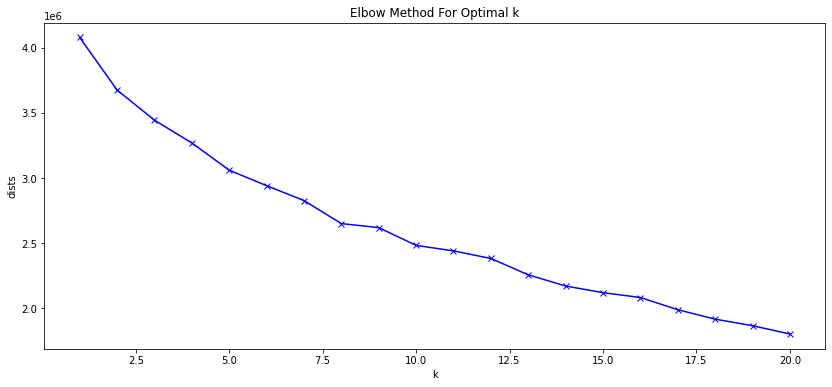

In [0]:
plt.plot(K, dists, 'bx-')
plt.xlabel('k')
plt.ylabel('dists')
plt.title('Elbow Method to Find Optimal k')
plt.show()

In [0]:
def get_outliers_kmeans(scaled_np, k):
  kmeans = KMeans(k)
  kfit = kmeans.fit(scaled_np)
  identified_clusters = kfit.predict(scaled_np)
  
  clustered_data = pd.DataFrame()

  clustered_data['cluster8'] = identified_clusters
  X_dist = kmeans.transform(scaled_np)**2
  clustered_data['sqdist8'] = X_dist.sum(axis=1)

  outlier_dist8 = [y for stat in boxplot_stats(clustered_data['sqdist8']) for y in stat['fliers']]

  clustered_data['label']= (clustered_data['sqdist8']>min(outlier_dist8)).astype('int32')
  return clustered_data, clustered_data['label'].to_numpy()


In [0]:
df_list[3].shape

(69107, 65)

In [0]:
_, seas_outliers_kmeans = get_outliers_kmeans(scaled_np=scaled_df_list[3], k=8)

In [0]:
print(seas_outliers_kmeans)

[0 0 0 ... 1 0 1]


In [0]:
# print(seas_df.shape)
# print(seas_outliers.shape)
# len(seas_outliers)/len(seas_df)

(69107, 65)
(7794, 67)


0.1127816284891545

In [0]:
# seas_outliers.head(10)

,BEN_TRANSACTION_AMOUNT,transaction_year,transaction_month,BENFPRD_PO_SHIPTO_ADDRESS1_freq_1.0,BENFPRD_PO_SHIPTO_ADDRESS1_freq_2.0,BENFPRD_PO_SHIPTO_ADDRESS1_freq_6.0,BENFPRD_PO_SHIPTO_ADDRESS1_freq_425.8000000000002,BENFPRD_PO_SHIPTO_ADDRESS1_freq_230587.86804397954,BENFPRD_PO_SHIPTO_LOC_CODE_freq_1.0,BENFPRD_PO_SHIPTO_LOC_CODE_freq_2.0,BENFPRD_PO_SHIPTO_LOC_CODE_freq_6.0,BENFPRD_PO_SHIPTO_LOC_CODE_freq_413.0,BENFPRD_PO_SHIPTO_LOC_CODE_freq_230544.4944849504,BEN_EXPENSE_COA_PROGRAM_CODE_freq_1.0,BEN_EXPENSE_COA_PROGRAM_CODE_freq_2.0,BEN_EXPENSE_COA_PROGRAM_CODE_freq_8.0,BEN_EXPENSE_COA_PROGRAM_CODE_freq_278.4000000000001,BEN_EXPENSE_COA_PROGRAM_CODE_freq_2170.8999999999974,BEN_EXPENSE_COA_CREF_CODE_freq_1.0,BEN_EXPENSE_COA_CREF_CODE_freq_2.0,BEN_EXPENSE_COA_CREF_CODE_freq_9.0,BEN_EXPENSE_COA_CREF_CODE_freq_189.0,BEN_EXPENSE_COA_CREF_CODE_freq_1075.0,BEN_EXPENSE_COA_OBJ_CATEGORY_Academic Salaries,BEN_EXPENSE_COA_OBJ_CATEGORY_Capital Transactions,BEN_EXPENSE_COA_OBJ_CATEGORY_Cash Effect,BEN_EXPENSE_COA_OBJ_CATEGORY_Current Expense,BEN_EXPENSE_COA_OBJ_CATEGORY_Investment Income,BEN_EXPENSE_COA_OBJ_CATEGORY_Other Income,BEN_EXPENSE_COA_OBJ_CATEGORY_Tuition & Fees,BEN_EXPENSE_COA_FUND_TYPE_Endowments,BEN_EXPENSE_COA_FUND_TYPE_Gifts,BEN_EXPENSE_COA_FUND_TYPE_Grants,BEN_EXPENSE_COA_FUND_TYPE_Other Purposes,BEN_EXPENSE_COA_ORG_DESC_freq_1.0,BEN_EXPENSE_COA_ORG_DESC_freq_5.0,BEN_EXPENSE_COA_ORG_DESC_freq_90.0,BEN_EXPENSE_COA_ORG_DESC_freq_1036.6,BEN_EXPENSE_COA_ORG_DESC_freq_2388.9,BEN_EXPENSE_COA_FUND_CODE_freq_1.0,BEN_EXPENSE_COA_FUND_CODE_freq_2.0,BEN_EXPENSE_COA_FUND_CODE_freq_4.0,BEN_EXPENSE_COA_FUND_CODE_freq_85.0,BEN_EXPENSE_COA_FUND_CODE_freq_202.0,BEN_EXPENSE_COA_OBJECT_CODE_freq_1.0,BEN_EXPENSE_COA_OBJECT_CODE_freq_2.0,BEN_EXPENSE_COA_OBJECT_CODE_freq_19.599999999999994,BEN_EXPENSE_COA_OBJECT_CODE_freq_2058.8,BEN_EXPENSE_COA_OBJECT_CODE_freq_9124.600000000002,BEN_VENDOR_NAME_freq_1.0,BEN_VENDOR_NAME_freq_2.0,BEN_VENDOR_NAME_freq_3.0,BEN_VENDOR_NAME_freq_4.0,BEN_VENDOR_NAME_freq_153971.0,BEN_RECORD_IDENTIFIER_freq_1.0,BEN_RECORD_IDENTIFIER_freq_2.0,BENFPRD_PO_BUYER_PENN_ID_freq_102.0,BENFPRD_PO_BUYER_PENN_ID_freq_328.0,BENFPRD_PO_BUYER_PENN_ID_freq_53243.05800000251,BENFPRD_PO_BUYER_PENN_ID_freq_231278.0,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_1.0_y,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_2.0_y,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_36391.71999999994_y,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_130195.299999999_y,BENFPRD_PO_SHIPTO_POSTAL_CODE_freq_607751.1008600069_y,cluster8,sqdist8
777,31500.00,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,4,3451.556178
821,169.00,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,2744.859887
823,41.00,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,2744.859887
833,361.80,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,2644.044199
869,134.31,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,2657.327273
936,29.00,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,2657.327273
938,135.00,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,2657.327273
953,111.41,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,2883.142934
1273,586.00,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,4,3451.556178
2053,22.61,2018,5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0

## Isolation Forest

In [0]:
def get_outliers_iso(scaled_data, estimators=100):
  clf=IsolationForest(n_estimators=estimators, max_samples='auto',random_state=42)
  clf.fit(scaled_data)
  outliers = clf.predict(scaled_data)
  print(np.sum(outliers == -1) / len(scaled_data))
  return outliers

In [0]:
seas_outliers_iso = get_outliers_iso(scaled_df_list[3])

0.12820698337360903


In [0]:
type(np.array(seas_outliers_iso))

numpy.ndarray

## Local Outlier Factor

In [0]:
def get_outliers_lof(scaled_data, neighbors=100):
  lof_clf = LocalOutlierFactor(n_neighbors=neighbors)
  outliers = lof_clf.fit_predict(scaled_data)
  print(np.sum(outliers == -1) / len(scaled_data))
  return outliers

In [0]:
seas_outliers_lof = get_outliers_lof(scaled_df_list[3])

0.09741415486130203


In [0]:
def print_differences(my_pred_kmeans, my_pred_if, my_pred_lof):
    num_same = 0
    num_all_outlier = 0
    outliers_indices_list = []

    for i in range(0, len(my_pred_if)):
        # if my_pred_if[i] != my_pred_lof[i] or:
        #     num_diff = num_diff + 1
        if my_pred_kmeans[i] == 1 and my_pred_if[i]==-1 and my_pred_lof[i]==-1:
            num_all_outlier = num_all_outlier + 1
            outliers_indices_list.append(i)
        if my_pred_kmeans[i] == 0 and my_pred_if[i]==1 and my_pred_lof[i]==1:
            num_same = num_same + 1
    num_diff = len(my_pred_if) - (num_all_outlier + num_same)
    print("total points: " + str(len(my_pred_if)))
    print("number of outliers (kmeans): " + str(np.sum(my_pred_kmeans == 1)))
    print("number of outliers (if):  " +str(np.sum(my_pred_if == -1)))
    print("number of outliers (lof): " + str(np.sum(my_pred_lof == -1)))
    print("number of points that have conflicting classifications: " +str(num_diff))
    print("number of points that marked outlier by all: " +str(num_all_outlier))
    return outliers_indices_list

In [0]:
outliers_list=print_differences(seas_outliers_kmeans, seas_outliers_iso, seas_outliers_lof)

total points: 69107
number of outliers (kmeans): 9945
number of outliers (if):  8860
number of outliers (lof): 6732
number of points that have conflicting classifications: 15752
number of points that marked outlier by all: 819


In [0]:
print(outliers_list)

[109, 110, 111, 112, 215, 216, 217, 218, 294, 295, 394, 395, 396, 397, 434, 436, 437, 442, 601, 602, 603, 604, 612, 616, 658, 717, 718, 719, 720, 1079, 1080, 1081, 1083, 1099, 1300, 1303, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1318, 1319, 1320, 1321, 1330, 1775, 1776, 3135, 3138, 3237, 3238, 3750, 3758, 4545, 4556, 4615, 5028, 5030, 5708, 5724, 6361, 6362, 6711, 6901, 6902, 6926, 6989, 7084, 7840, 7863, 8171, 8172, 8297, 8934, 9376, 9462, 10493, 10495, 10810, 10894, 10896, 10898, 11115, 11326, 11332, 11341, 11344, 11507, 11510, 11571, 11572, 11573, 11578, 11706, 11710, 11878, 11879, 11928, 11929, 11941, 11947, 12125, 12127, 12247, 12250, 12860, 12864, 12943, 13313, 13314, 13383, 13454, 13456, 13590, 13646, 14070, 14323, 14485, 14488, 14624, 14626, 14712, 15085, 15205, 15253, 15270, 16172, 16174, 16175, 16180, 17080, 17082, 17260, 17514, 17519, 17520, 17613, 17623, 18328, 18330, 18437, 18438, 18439, 18596, 18598, 18786, 18864, 19288, 19293, 19679, 19680, 20645, 20686, 20688, 20

## All Model Function
-- Final function to call that runs all 3 models and returns indices of the final outliers

-- Should run on **scaled data**

-- Also prints some stuff as shown above

** Note that for the kmeans model, outliers are denoted as 1 and regulars are denoted 0

** For the other models, outliers are denoted -1 and regulars are 1

----

-- For kmeans, $k$ can be optimized by looking at the elbow plot.

-- For the LOF model, more neighbors is typically better (esp. with very large sizes of data), but the model becomes slow very quickly as neighbors increases.

In [0]:
def run_all_models(scaled_df, k=8, estimators=100, neighbors=100):
  _, seas_outliers_kmeans = get_outliers_kmeans(scaled_np=scaled_df, k=k)
  seas_outliers_iso = get_outliers_iso(scaled_df, estimators=estimators)
  seas_outliers_lof = get_outliers_lof(scaled_df, neighbors=neighbors)
  outliers_list = print_differences(seas_outliers_kmeans, seas_outliers_iso, seas_outliers_lof)
  return outliers